## Necessary Functions

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def read_reward_column(csv_file_path, reward_column="reward", action_column="action"):
    """
    Reads the reward column from a CSV file and plots its values with different colors 
    based on the corresponding action values. A line is drawn to connect the points.

    Args:
        csv_file_path (str): Path to the CSV file.
        reward_column (str): Column name containing reward values.
        action_column (str): Column name containing action values.

    Returns:
        pandas.Series: The reward column data.
    """
    # Load the CSV file
    data = pd.read_csv(csv_file_path)

    # Check if required columns exist
    if reward_column not in data.columns:
        raise ValueError(f"Column '{reward_column}' not found in the CSV file.")
    if action_column not in data.columns:
        raise ValueError(f"Column '{action_column}' not found in the CSV file.")

    # Extract relevant data
    rewards = data[reward_column]
    actions = data[action_column]

    # Define color map for actions
    color_map = {
        0: 'green',   # Keep ensemble
        1: 'yellow',  # Add model
        2: 'blue',    # Replace model
        3: 'red'      # Remove model
    }

    # Define action descriptions for the legend
    action_descriptions = {
        0: "Keep Ensemble",
        1: "Add Model",
        2: "Replace Model",
        3: "Remove Model"
    }

    # Assign colors based on action values
    colors = [color_map.get(action, 'gray') for action in actions]  # Default to gray if unknown action

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot the line connecting the rewards
    plt.plot(range(len(rewards)), rewards, linestyle='-', color='black', alpha=0.5, label="Reward Trend")

    # Overlay the scatter plot with action-based colors
    plt.scatter(range(len(rewards)), rewards, c=colors, edgecolors='black', label="Reward Values")

    # Create legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markersize=10, 
                   markerfacecolor=color_map[key], label=f"Action {key}: {action_descriptions[key]}")
        for key in color_map
    ]
    plt.legend(handles=legend_handles, title="Actions", loc="upper left")

    # Customize plot
    plt.title(f'Reward Plot Colored by Action with Trend Line')
    plt.xlabel('Index')
    plt.ylabel('Reward')
    plt.grid(True)

    # Show the plot
    plt.show()

    return rewards


## Reading the data

In [19]:
csv_file_path = "results/ppo/reinforcement_learning.csv"

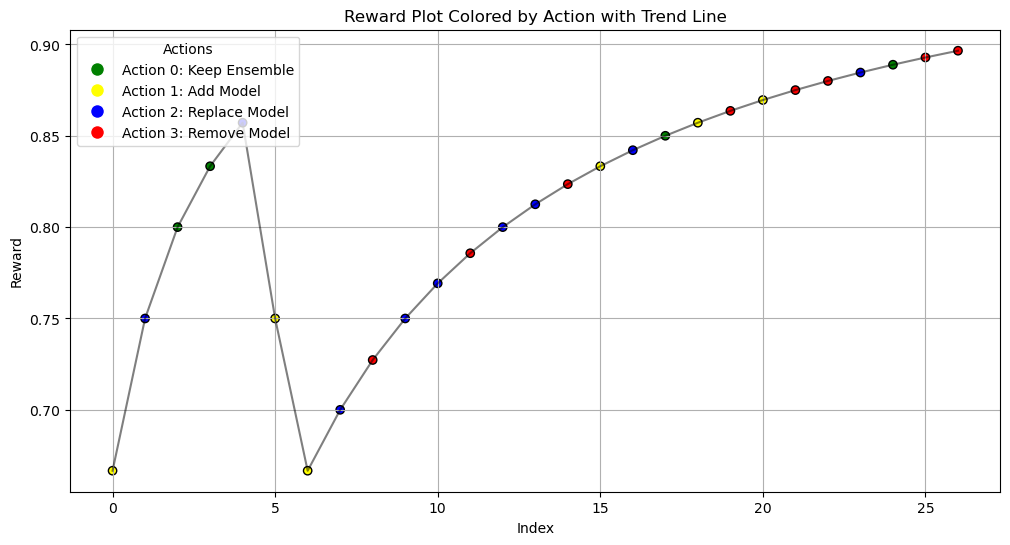

0     0.666667
1     0.750000
2     0.800000
3     0.833333
4     0.857143
5     0.750000
6     0.666667
7     0.700000
8     0.727273
9     0.750000
10    0.769231
11    0.785714
12    0.800000
13    0.812500
14    0.823529
15    0.833333
16    0.842105
17    0.850000
18    0.857143
19    0.863636
20    0.869565
21    0.875000
22    0.880000
23    0.884615
24    0.888889
25    0.892857
26    0.896552
Name: ensemble_accuracy, dtype: float64

In [23]:
read_reward_column(csv_file_path, "ensemble_accuracy")